# Paper Plots

Run this notebook from start to finish to (re)generate all the plots for the paper.

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [28]:
using ArviZ
using DimensionalData
using Distributions
using Bump10MSun
using LaTeXStrings
using StatsBase
using StatsFuns
using StatsPlots
using Trapz

## Preliminaries, Loading Data

In [3]:
pyplot()

Plots.PyPlotBackend()

Setting up reasonable plotting defaults:

In [4]:
colwidth_pt = 433.62
colwidth_in = colwidth_pt / 72.0
ppi = 300.0
fsize = 20
default(size=(ppi*colwidth_in, ppi*colwidth_in), dpi=ppi, legend_font_pointsize=fsize, tickfontsize=fsize, guidefontsize=fsize)

Loading up the PE samples we are analyzing: adjust the paths below to match what is stored on your computer.

In [5]:
sampso3a, fnameso3a, gwnameso3a = load_pe_samples("/Users/wfarr/Research/o3a_posterior_samples/all_posterior_samples", "GW*[0-9].h5", "PublicationSamples/posterior_samples")
sampso3b, fnameso3b, gwnameso3b = load_pe_samples("/Users/wfarr/Research/o3b_data/PE", "*GW*_nocosmo.h5", "C01:Mixed/posterior_samples")

samps = vcat(sampso3a, sampso3b)
fnames = vcat(fnameso3a, fnameso3b)
gwnames = vcat(gwnameso3a, gwnameso3b)

mask = map(samps) do ss
    m1s = [x.mass_1_source for x in ss]
    m2s = [x.mass_2_source for x in ss]

    sel = isselected.(m1s, m2s)
    sum(sel) > 9*length(sel)/10
end
samps = samps[mask]
fnames = fnames[mask]
gwnames = gwnames[mask]

19-element Vector{String}:
 "GW190412"
 "GW190512_180714"
 "GW190707_093326"
 "GW190708_232457"
 "GW190720_000836"
 "GW190728_064510"
 "GW190828_065509"
 "GW190924_021846"
 "GW190930_133541"
 "GW191103_012549"
 "GW191105_143521"
 "GW191113_071753"
 "GW191126_115259"
 "GW191129_134029"
 "GW191204_171526"
 "GW191216_213338"
 "GW200202_154313"
 "GW200225_060421"
 "GW200316_215756"

Let's load the traces for all the models we have:

In [6]:
traces = Dict(k => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * ".nc")) for k in keys(suffix_map))

Dict{Tuple{MassFunction, PairingFunction}, InferenceData{(:posterior, :sample_stats)}} with 5 entries:
  (BrokenPowerLaw(), Power… => InferenceData{(:posterior, :sample_stats), Tuple…
  (PowerLawGaussian(), Pow… => InferenceData{(:posterior, :sample_stats), Tuple…
  (TwoBrokenPowerLaw(), Ga… => InferenceData{(:posterior, :sample_stats), Tuple…
  (BrokenPowerLaw(), Gauss… => InferenceData{(:posterior, :sample_stats), Tuple…
  (TwoBrokenPowerLaw(), Po… => InferenceData{(:posterior, :sample_stats), Tuple…

Compute various distributional quantities for each model:

In [7]:
ms = exp.(range(log(mlow), stop=log(mhigh), length=128))
qs = collect(range(mlow/mhigh, stop=1, length=128))

function make_distribution_map(dN_maker, xs)
    Dict(
        k => map([traces[k].posterior[v] for v in var_name_map[k]]...) do R, args...
            dN = dN_maker(k[1], k[2], args...)
            R .* dN.(xs)
        end for k in keys(traces)
    )
end

dNdm1s = make_distribution_map(make_dNdm1, ms)
dNdm2s = make_distribution_map(make_dNdm2, ms)
dNdqs = make_distribution_map(make_dNdq, qs)

pms = Dict(
    k => map([traces[k].posterior[v] for v in mf_var_name_map[k[1]]]...) do R, args...
        p = make_dNdm(k[1], args...)
        pp = p.(ms)
        pp .= pp ./ trapz(ms, pp)
        pp
    end for k in keys(traces)
);

## Figure 1

In Figure 1, we plot the PE samples (likelihood-weighted) that we are analyzing:

In [18]:
function bisect(f, xl, xh)
    bisect_loop(f, f(xl), f(xh), xl, xh)
end
function bisect_loop(f, fl, fh, xl, xh)
    if xh - xl < 1e-8
        (xh+xl)/2
    else
        xm = (xh+xl)/2
        fm = f(xm)

        if fl*fm < 0
            bisect_loop(f, fl, fm, xl, xm)
        else
            bisect_loop(f, fm, fh, xm, xh)
        end
    end
end

bisect_loop (generic function with 1 method)

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


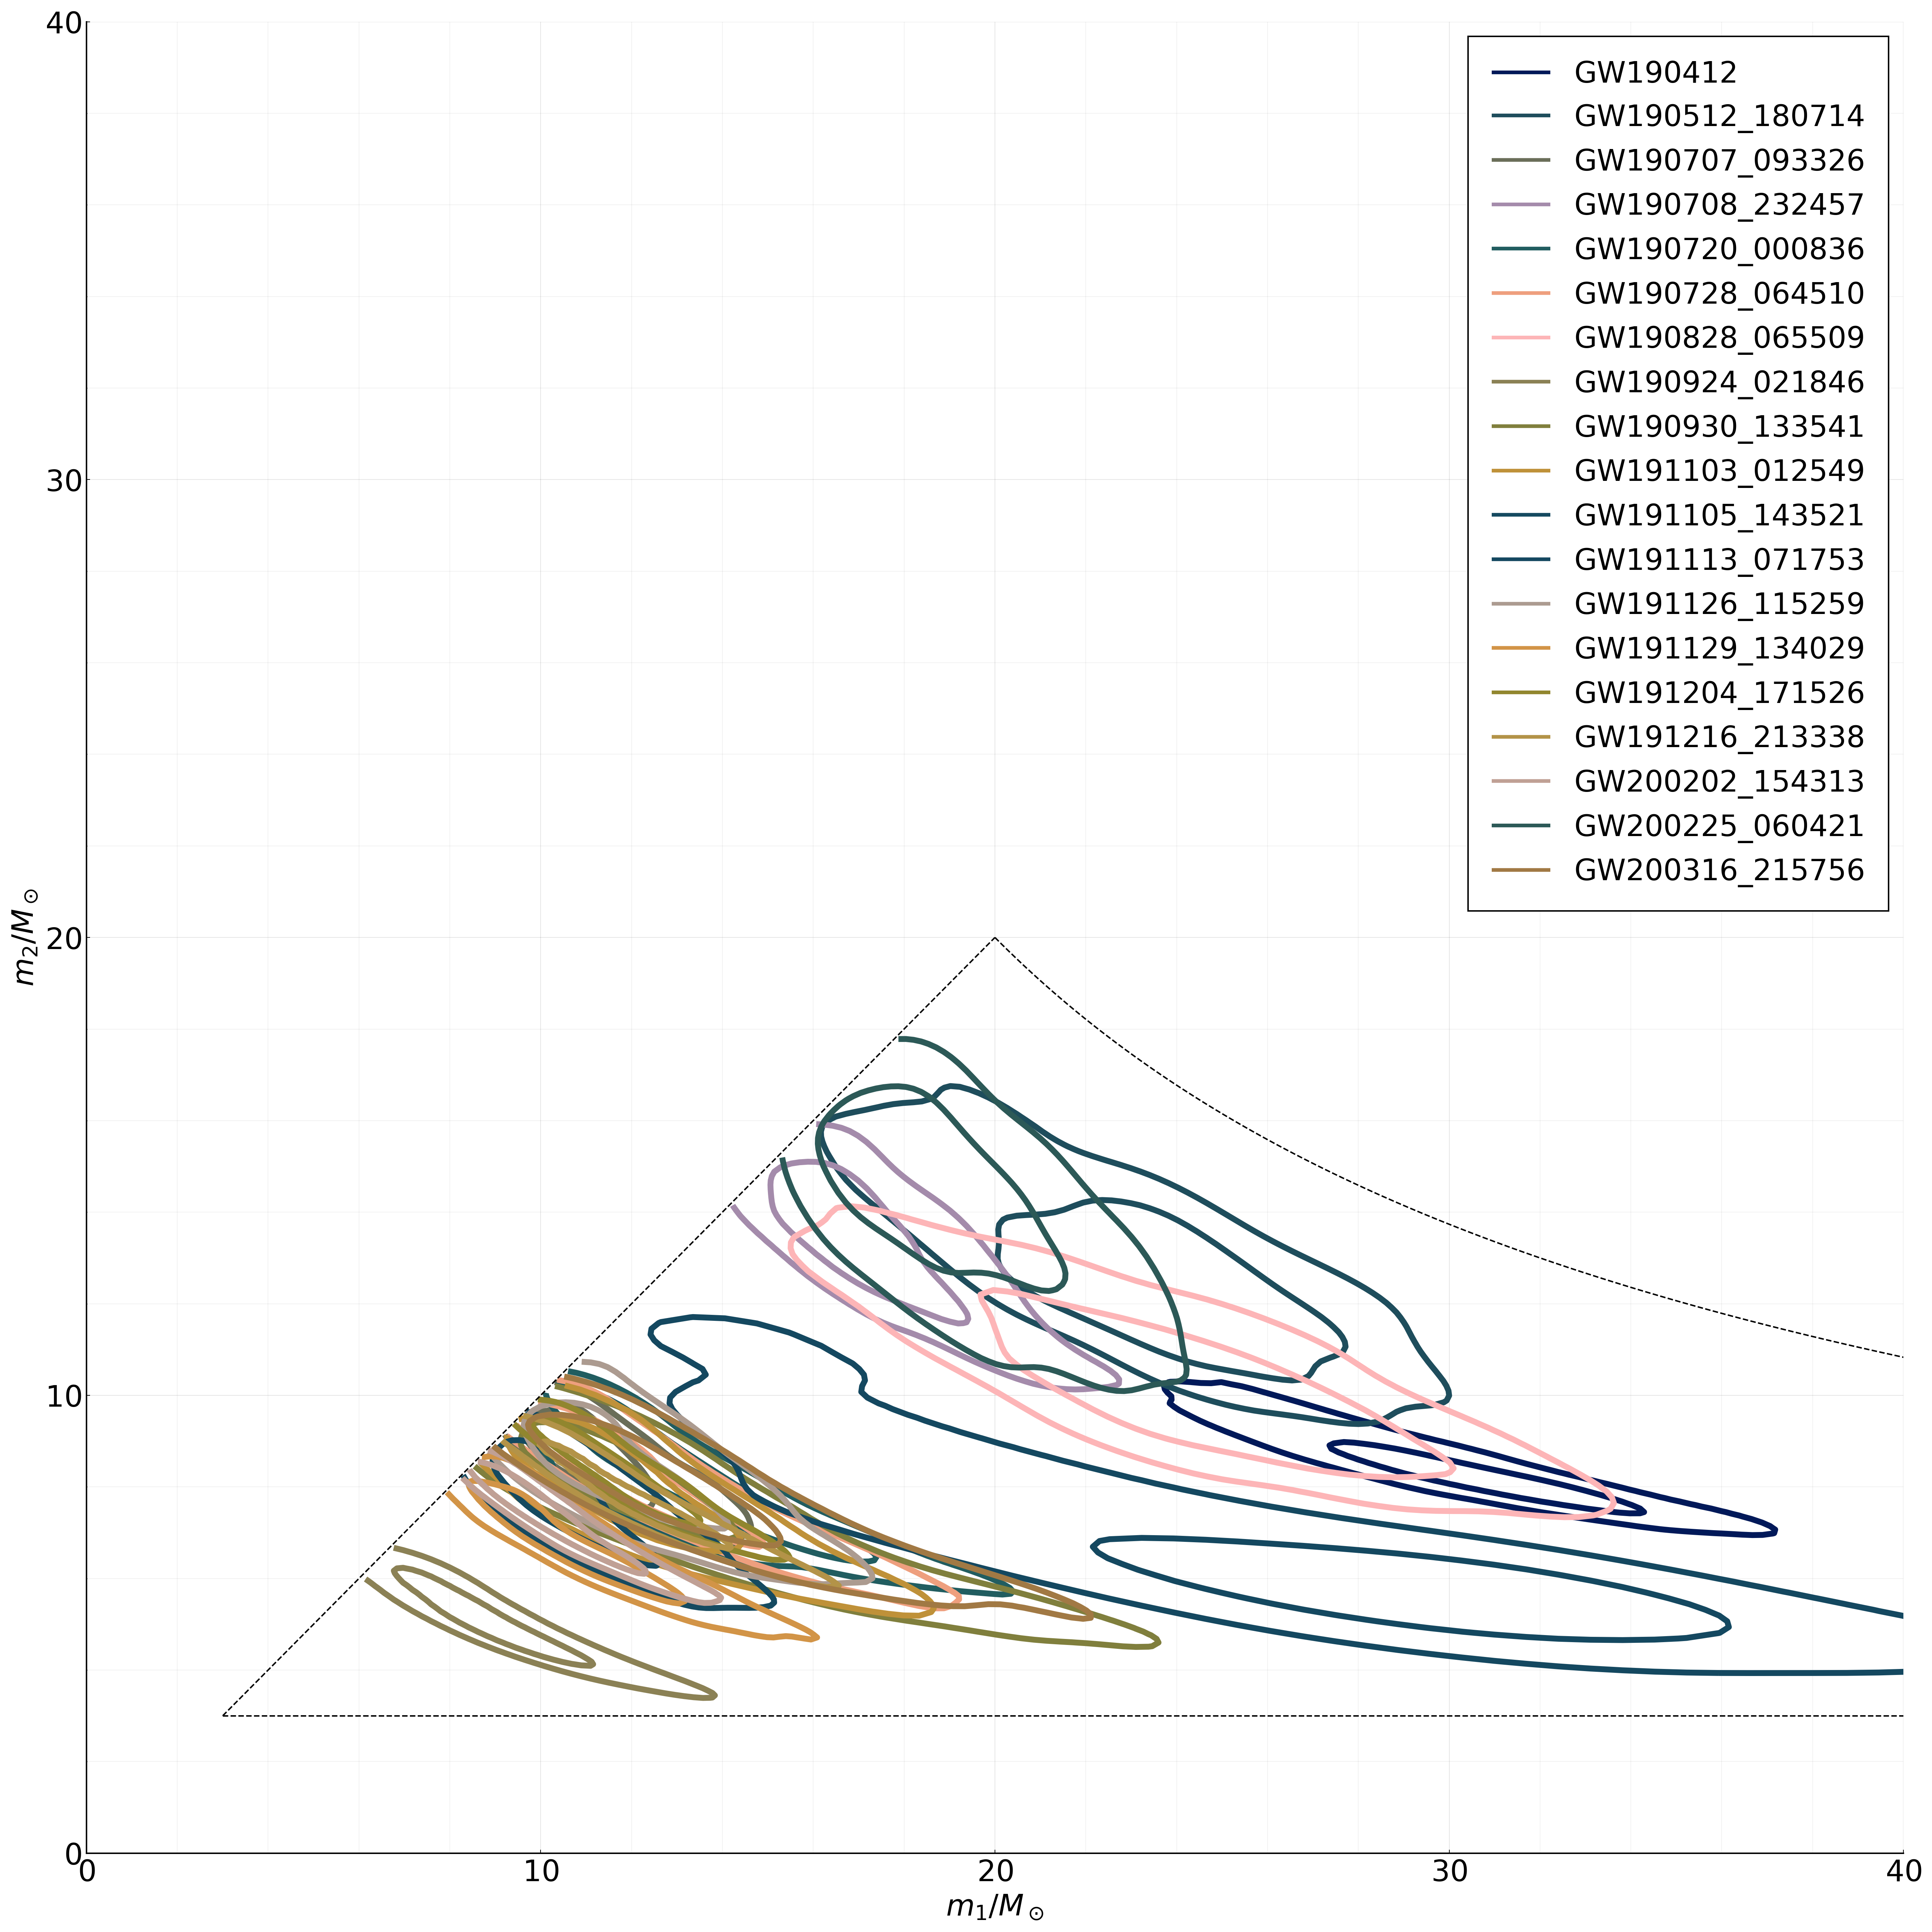

"/Users/wfarr/Research/Bump10MSun/paper/figures/m1-m2-contour.pdf"

In [33]:
npt = 1024
cs = palette(:batlowS, length(gwnames)+1)
xmax = 40
ymax = 40
p = plot(xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", palette=cs, xlims=(0, xmax), ylims=(0, ymax), minorgrid=true)
for (i, (n, s)) in enumerate(zip(gwnames, samps))
    m1 = [x.mass_1_source for x in s]
    m2 = [x.mass_2_source for x in s]
    z = [x.redshift for x in s]
    wt = md_sfr_zwt.(z) ./ li_prior_wt.(m1, m2, z)
    inds = sample(1:length(z), Weights(wt), npt)
    m1 = m1[inds]
    m2 = m2[inds]

    pts = vcat(m1', m2')
    k = KDE(pts)
    inds = sample(1:size(pts, 2), 128)
    cpts = pts[:, inds]
    ls = logpdf_credible_levels(k, cpts, [0.1, 0.5])

    sig_m1 = std(m1)
    sig_m2 = std(m2)
        
    x = collect(range(minimum(m1)-sig_m1, stop=maximum(m1)+sig_m1, length=129))
    y = collect(range(minimum(m2)-sig_m2, stop=maximum(m2)+sig_m2, length=127))

    Z = [(xx > yy ? logpdf(k, [xx, yy]) : -Inf) for xx in x, yy in y]
    p = contour!(x, y, Z', levels=ls, color=[cs[i], cs[i]], cbar=false, lw=4)
    p = plot!([], [], label=n, lw=4, color=cs[i])
end

mc20 = chirp_mass(20, 20)
xmc = range(20, stop=xmax, length=128)
ymc = [bisect(m2 -> chirp_mass(m1, m2) - mc20, 0, 20) for m1 in xmc]
p = plot!(xmc, ymc, color=:black, ls=:dash, label=nothing)
p = plot!(range(mlow, xmax, length=10), mlow .* ones(10), color=:black, ls=:dash, label=nothing)
p = plot!(range(mlow, 20, length=10), range(mlow, 20, length=10), color=:black, ls=:dash, label=nothing)

savefig(p, joinpath(@__DIR__, "..", "paper", "figures", "m1-m2-contour.pdf"))